# Heart Failure Prediction - IA01 Project Autumn 2025
# UTT - Introduction to Artificial Intelligence
 
This notebook contains the exploratory data analysis, data preprocessing, 
and machine learning modeling steps for predicting heart failure. 
The dataset used combines multiple sources including Cleveland, Hungarian, 
Switzerland, Long Beach VA, and Stalog datasets, resulting in 918 observations 
after removing duplicates.

The goal is to analyze the dataset, identify important features, 
train several classification models (kNN, Decision Tree, Random Forest,
Logistic Regression, Neural Networks), and evaluate their performance.


# Helpers

In [2]:
def hist_box(feature, data):
    """
    Plots histogram and boxplot for a single feature in a dataset.

    Parameters:
    - feature: str, column name in the DataFrame
    - data: pd.DataFrame, dataset containing the feature
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram
    sns.histplot(data[feature], kde=True, ax=axes[0], color="#4c72b0")
    axes[0].set_title(f"{feature} distribution")

    # Boxplot
    sns.boxplot(x=data[feature], ax=axes[1], color="#55a868")
    axes[1].set_title(f"{feature} boxplot")

    plt.tight_layout()
    plt.show()


In [3]:
def IQR(feature, data):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# We import important libraries to analyze the dataset
 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer

# EDA

## Dataset Loading & Basic Structure

In [5]:
heart_data = pd.read_csv('../data/heart.csv')
print(f"In our dataset we have {heart_data.shape[0]} rows and {heart_data.shape[1]} columns\n")
print(heart_data.head())

In our dataset we have 918 rows and 12 columns

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [6]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Start of Feature analysis

In [8]:
numerical_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
# categorical variables - maybe one-hot encoding
nominal_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina"]
# categorical variable with order which is important
ordinal_features = ["ST_Slope"]
binary_features = ["FastingBS"]
for feature in ordinal_features:
    print(heart_data[feature].unique())
target_feature = ["HeartDisease"]


print("Feature groups:")
print("Numerical:", numerical_features)
print("Nominal:", nominal_features)
print("Ordinal:", ordinal_features)
print("Binary:", binary_features)
print("Target:", target_feature)

['Up' 'Flat' 'Down']
Feature groups:
Numerical: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Nominal: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina']
Ordinal: ['ST_Slope']
Binary: ['FastingBS']
Target: ['HeartDisease']


## Univariate Analysis — Numeric Features

In [9]:
numeric_features = heart_data.select_dtypes(include='number').columns.tolist()

In [10]:
print(numeric_features)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


### Age analysis

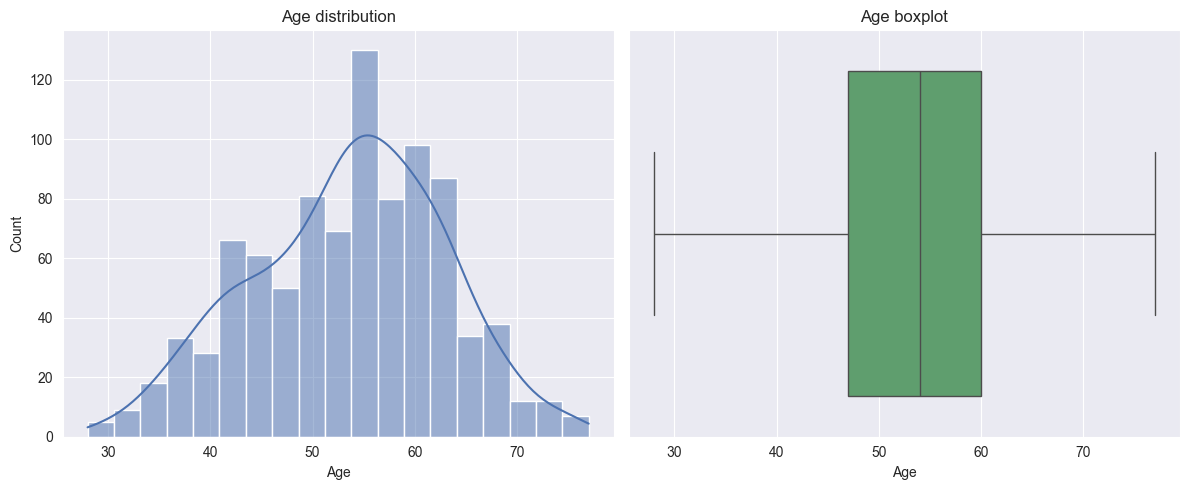

In [11]:
hist_box(numeric_features[0], heart_data)

- The histogram shows that **Age** is approximately normally distributed, with most patients between **45 and 65 years old**, which is typical for a heart-disease-focused dataset.
- The boxplot indicates a relatively symmetric distribution with no extreme outliers.
- Conclusion: Age is a clean and reliable feature, that describes the population that is from middle-aged to older adults, aligning with known risk groups for heart disease.

### RestingBP analysis

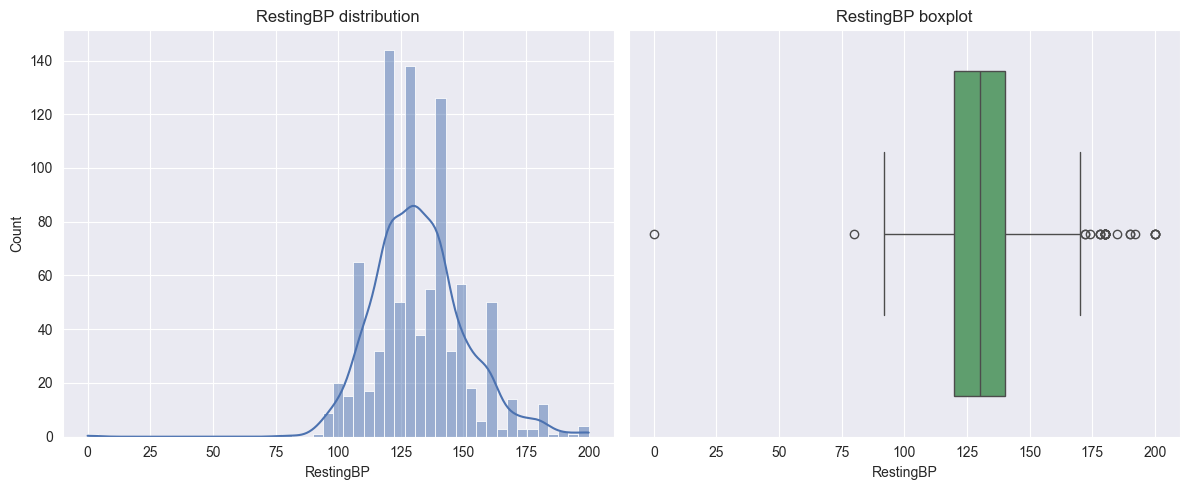

In [12]:
hist_box(numeric_features[1], heart_data)

In [13]:
print(f"We have {heart_data.RestingBP[heart_data['RestingBP'] > IQR('RestingBP', heart_data)[1]].count()} values that look like outliers (higher than {IQR('RestingBP', heart_data)[1]})")

We have 26 values that look like outliers (higher than 170.0)


   - The histogram for **RestingBP** shows a roughly centered distribution around **120–140 mmHg**, which is consistent with typical resting blood pressure ranges in adults.
   - A single value at **0 mmHg** appears in both the histogram and boxplot, which is physiologically impossible and indicates an erroneous or missing measurement.
   - The boxplot also reveals several high outliers above **170 mmHg**, we can conclude that these values are likely describing hypertensive patients rather than data errors.

### Cholesterol analysis

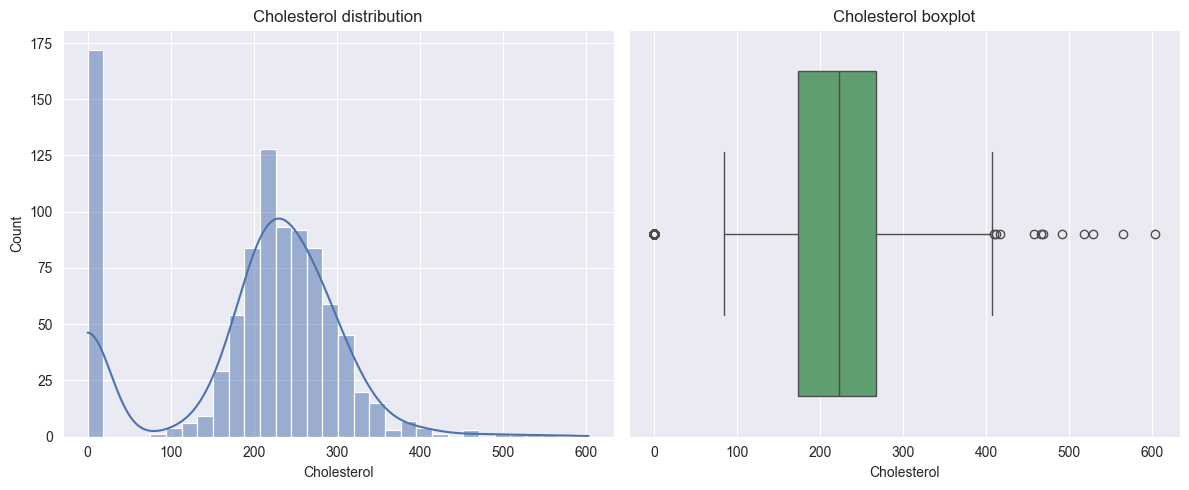

In [14]:
hist_box(numeric_features[2], heart_data)

In [15]:
print(f"We have {heart_data.Cholesterol[heart_data.Cholesterol > IQR('Cholesterol', heart_data)[1]].count()} values that look like outliers, but are clinically plausible")
print(f"We have {heart_data.Cholesterol[heart_data.Cholesterol == 0].count()} values that are equals 0, which is medically impossible and indicates erroneous or missing cholesterol values that must be corrected")

We have 11 values that look like outliers, but are clinically plausible
We have 172 values that are equals 0, which is medically impossible and indicates erroneous or missing cholesterol values that must be corrected


- The histogram shows a large spike at **0 mg/dl**, which is medically impossible and indicates erroneous or missing cholesterol values that must be corrected.
- Among valid measurements, cholesterol follows a right-skewed distribution centered around **200–260 mg/dl**, with several high outliers above **400 mg/dl**.
- The boxplot confirms both the invalid zero values and the presence of clinically plausible high-cholesterol outliers.

### FastingBS analysis

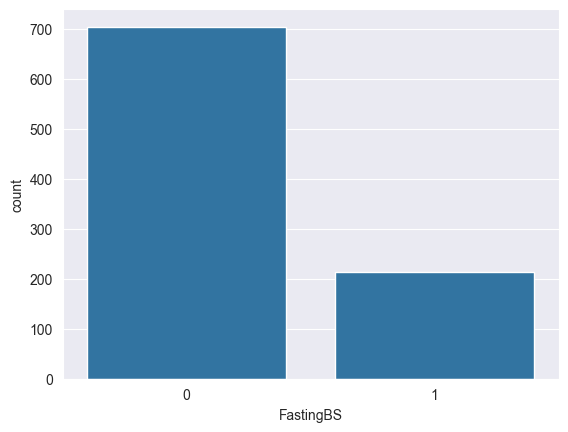

In [16]:
sns.countplot(x=numeric_features[3], data=heart_data)
plt.show()

In [17]:
fastingBS_info = heart_data.FastingBS.value_counts(normalize=True)
print(f"We have {fastingBS_info[0] * 100:.2f} % of patients who have normal glucose levels and {fastingBS_info[1] * 100:.2f} % of patients who have elevated fasting blood sugar")

We have 76.69 % of patients who have normal glucose levels and 23.31 % of patients who have elevated fasting blood sugar


 - The bar plot shows that most patients have a fasting blood sugar value of **0**, meaning normal glucose levels, while a smaller portion 23.31 % have elevated fasting blood sugar (value **1**). This reflects the expected distribution in a general or clinical population, where high fasting sugar is less common. Because FastingBS is a binary variable, no outliers or unusual patterns are present.

### MaxHR analysis

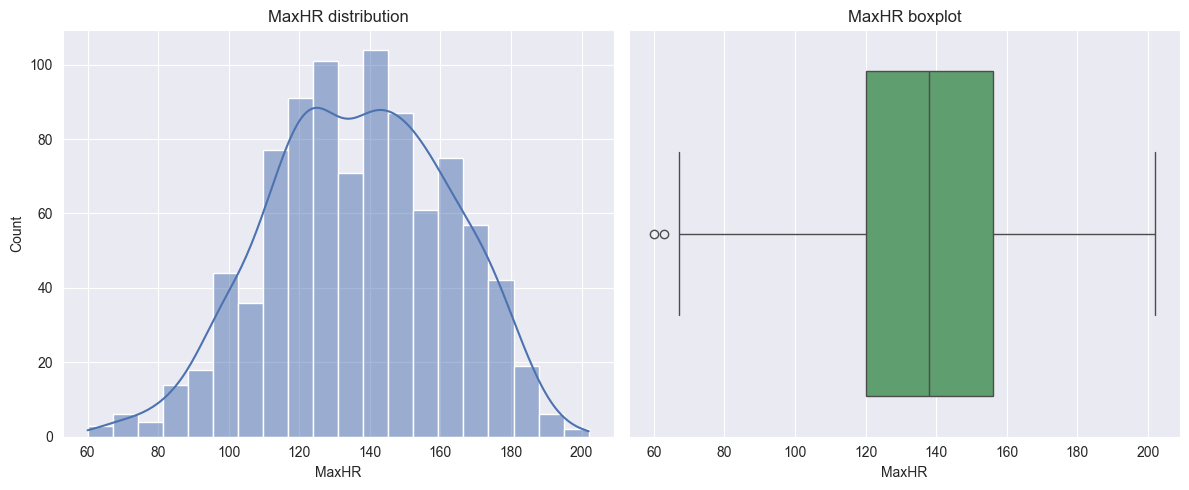

In [18]:
hist_box(numeric_features[4], heart_data)

In [19]:
print(f"We have {heart_data.MaxHR[heart_data.MaxHR < IQR(numeric_features[4], heart_data)[0]].count()} values that are less than {IQR(numeric_features[4], heart_data)[0]} that can represent an unusual clinical cases because most values are between 120 and 160bpm")

We have 2 values that are less than 66.0 that can represent an unusual clinical cases because most values are between 120 and 160bpm


- The histogram shows that MaxHR is mostly concentrated between **120 and 160 bpm**, forming an approximately bell-shaped distribution typical for exercise stress testing.
- A small number of very low values, such as **60 bpm**, appear in the boxplot and represent unusual or clinically concerning cases, possibly due to incomplete exercise tests or severe cardiac limitations. Overall, the feature looks clean but contains a few physiologically extreme low outliers worth noting.

###  Oldpeak analysis

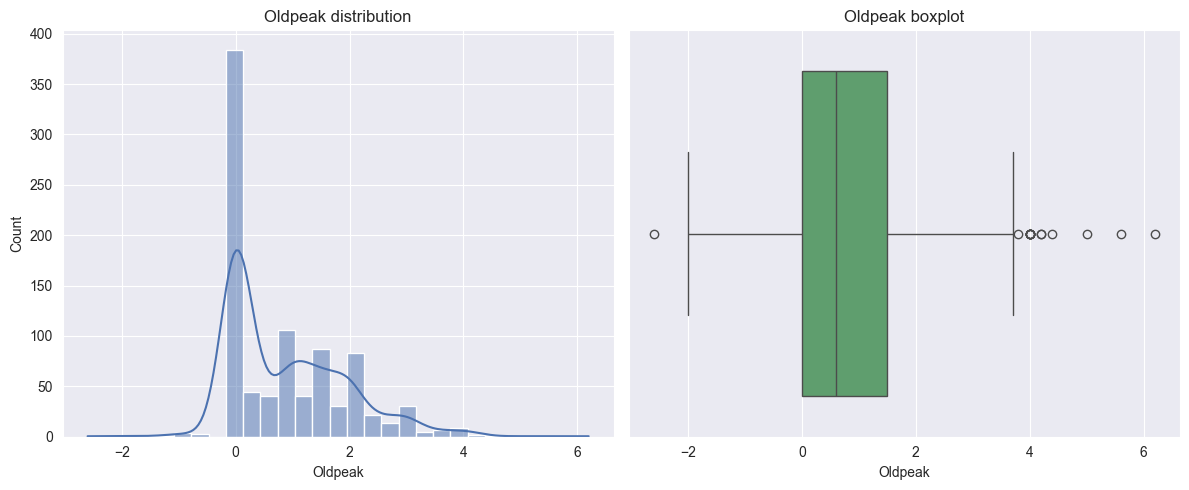

In [20]:
hist_box(numeric_features[5], heart_data)

In [21]:
print(f"We have {heart_data.Oldpeak[heart_data.Oldpeak < 0].count()} that are less than 0 that can be strange and we can probably replace them by 0")
print(f"We have also {heart_data.Oldpeak[heart_data.Oldpeak > IQR(numeric_features[5], heart_data)[1]].count()} values that are outliers and higher than {IQR(numeric_features[5], heart_data)[1]}")

We have 13 that are less than 0 that can be strange and we can probably replace them by 0
We have also 15 values that are outliers and higher than 3.75


- The histogram shows that Oldpeak is heavily right-skewed, with the majority of values clustered at 0, indicating no ST depression during exercise, while higher values up to **6** represent more severe abnormalities.
- The boxplot highlights several high outliers above **4**, which likely correspond to patients with significant cardiac stress responses. A few negative values also appear, which can occur due to ECG baseline shifts, but they remain rare and should be kept in mind during preprocessing.

## Univariate Analysis — Ordinal Features

In [22]:
print(ordinal_features)

['ST_Slope']


### St_Slope analysis

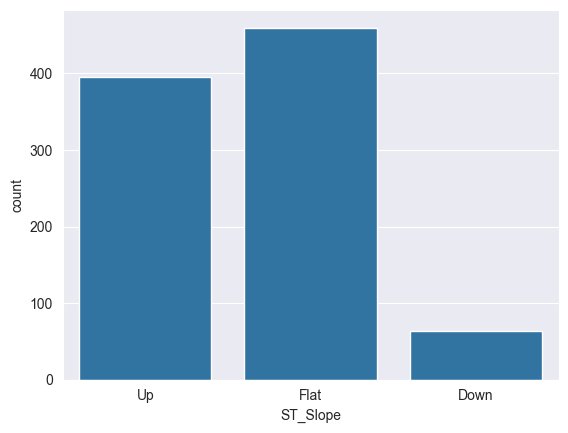

We have 460 flat values,  395 up values and 63 down values


In [23]:
sns.countplot(x="ST_Slope", data=heart_data)
plt.show()
st_slope_info = heart_data["ST_Slope"].value_counts().tolist()
print(f"We have {st_slope_info[0]} flat values,  {st_slope_info[1]} up values and {st_slope_info[2]} down values")

The analysis of the ST_Slope variable shows that the categories are imbalanced, with most observations labeled as Flat or Up, and relatively few labeled as Down. Despite this imbalance, the ordered nature of the feature makes it medically and statistically meaningful.

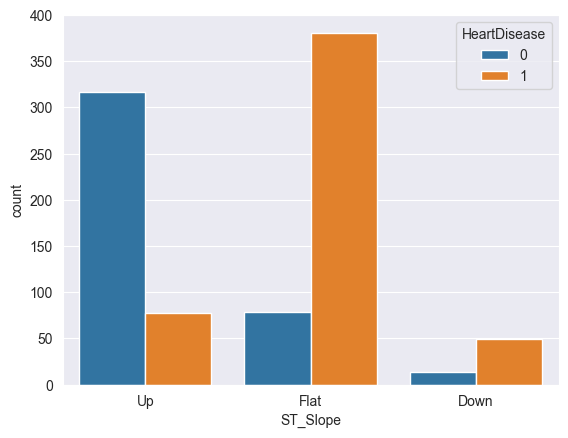

In [24]:
sns.countplot(data=heart_data, x="ST_Slope", hue="HeartDisease")
plt.show()

Comparing ST_Slope with the target variable (Heart disease) can bring us to this conclusion:
- Individuals with a **Flat** ST_Slope are most likely to have Heart Disease
- A majority of individuals with an **Up** ST_Slope do not have Heart Disease
- While the overall counts are low for this group, those with a **Down** ST_Slope are also more likely to have Heart Disease

## Univariate Analysis — Nominal Features

In [25]:
print(nominal_features)

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina']


### Sex

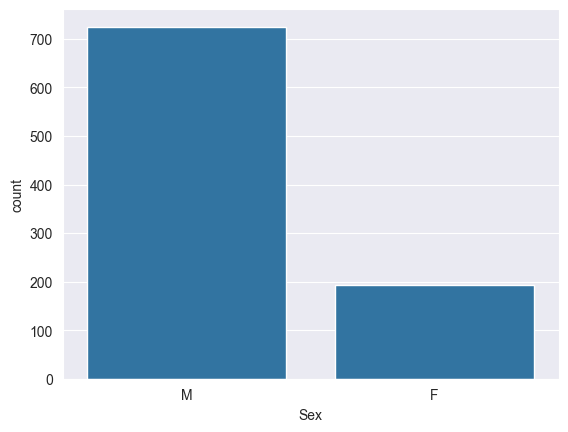

[725, 193]


In [26]:
sns.countplot(x="Sex", data=heart_data)
plt.show()
sex_info = heart_data["Sex"].value_counts().tolist()
print(sex_info)

We can conclude that we have much more men instances than women.

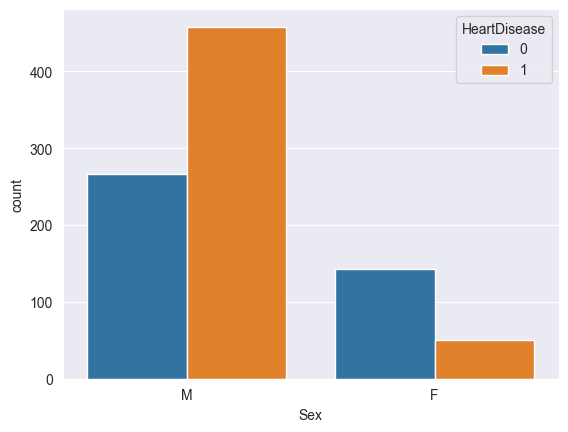

In [27]:
sns.countplot(x="Sex", data=heart_data, hue="HeartDisease")
plt.show()

We can summarize that in the male sample, the probability of having heart disease is about one and a half times higher than not having it. At the same time, in the female sample, the absence of heart disease is almost three times more likely than its presence.

### Exercise Angina

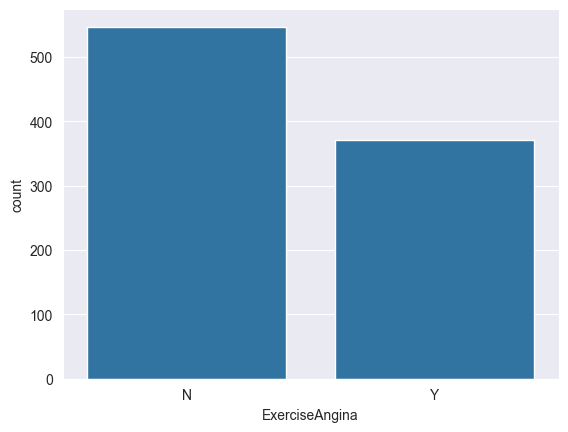

[547, 371]


In [28]:
sns.countplot(x="ExerciseAngina", data=heart_data)
plt.show()
sex_info = heart_data["ExerciseAngina"].value_counts().tolist()
print(sex_info)

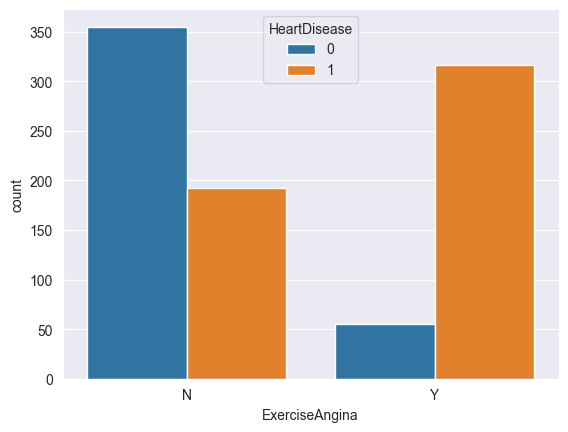

In [29]:
sns.countplot(x="ExerciseAngina", data=heart_data, hue="HeartDisease")
plt.show()

We can conclude that among individuals without exercise-induced angina (N), the number of people without heart disease is substantially higher than those with heart disease. In contrast, among individuals with exercise-induced angina (Y), the number of people with heart disease greatly exceeds those without it.

### RestingECG

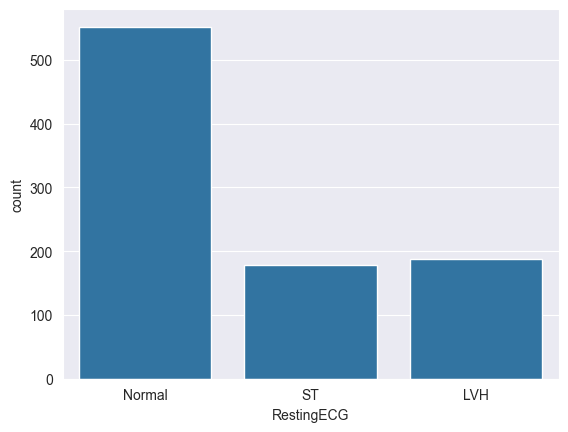

[552, 188, 178]


In [30]:
sns.countplot(x="RestingECG", data=heart_data)
plt.show()
restingECG_info = heart_data["RestingECG"].value_counts().tolist()
print(restingECG_info)

The RestingECG variable is dominated by the Normal category, while LVH and ST are less frequent. This imbalance should be considered when analyzing its relationship with heart disease. Despite fewer cases in LVH and ST, differences across categories may still provide valuable insights into cardiac risk and can be used effectively in predictive modeling after appropriate encoding.

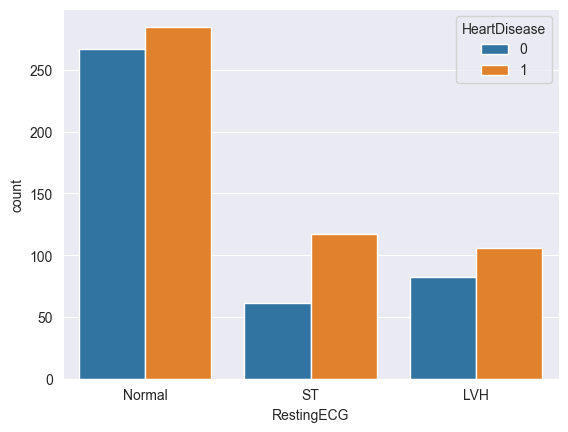

In [31]:
sns.countplot(data=heart_data, x="RestingECG", hue="HeartDisease")
plt.show()

The RestingECG provide 3 groups: Normal, ST and Left Ventricular Hypertrophy(LVH).
- Normal:
    - Has the largest total number of people
    - Having a 'Normal' RestingECG does not guarantee the absence of heart disease, as the disease is slightly more prevalent even in this group.
- ST:
    - The count of Heart Disease is clearly much higher than the count of no Heart Disease
    - This group can be a strong indicator for the presence of Heart Disease
- LVH:
    - The count for Heart Disease is higher than the count for no Heart Disease
    - Left Ventricular Hypertrophy is also associated with a higher likelihood of Heart Disease.

### ChestPainType

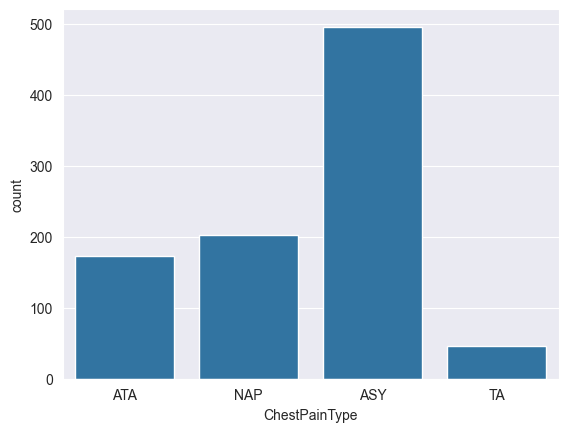

{'ASY': 496, 'NAP': 203, 'ATA': 173, 'TA': 46}


In [32]:
sns.countplot(data=heart_data, x="ChestPainType")
plt.show()
print(heart_data.ChestPainType.value_counts().to_dict())

We have 4 different groups of **chain pain type**: ATA, NAP, ASY, TA. The ChestPainType variable is heavily skewed toward ASY (Asymptomatic, 496 cases), followed by NAP (Non-Anginal Pain, 203 cases), ATA (Atypical Angina, 173 cases), and TA (Typical Angina, 46 cases). Most patients do not report significant chest pain (ASY), while the less frequent categories—especially TA—may indicate higher cardiac risk. Despite their smaller numbers, these rarer pain types provide important predictive information for heart disease when analyzed or properly encoded.

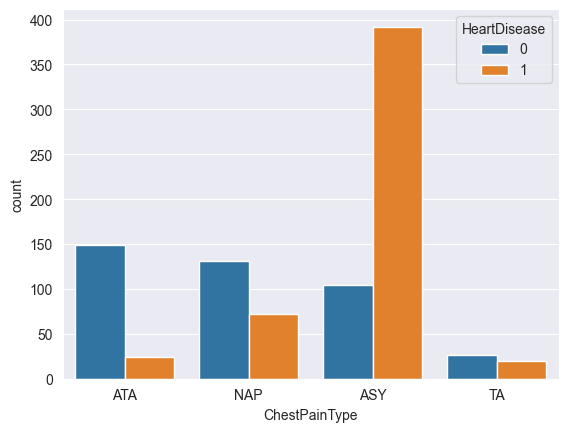

In [33]:
sns.countplot(data=heart_data, x="ChestPainType", hue="HeartDisease")
plt.show()

The ChestPainType provide 4 groups: ATA, NAP, ASY and TA.
- ATA
    - Is strongly associated with the absence of Heart Disease
- NAP
    - Absence of Heart Disease is significantly taller (130 vs 75)
- ASY
    - Highest total count of individuals
    - Associated with Heart Disease because have heart disease is four times higher than not
- TA
    - lowest total count of individuals
    - least informative, have very similar possibilities of having heart disease

## Univariate Analysis — Target Feature

### HeartDisease analysis

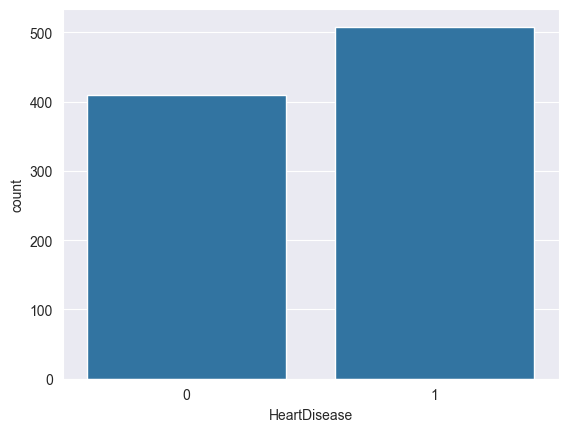

In [34]:
sns.countplot(x=numeric_features[6], data=heart_data)
plt.show()

- The target variable is fairly balanced, with slightly more patients labeled as having heart disease **(1)** than not **(0)**. This moderate class imbalance should not cause major issues during model training but may still benefit from stratified train–test splitting. Overall, the distribution indicates that the dataset contains sufficient examples of both classes for effective classification modeling.

## Descriptive Statistics (Numeric)

In [35]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The dataset contains 918 samples with seven numerical features, including the target variable `HeartDisease`.
- **Age** ranges from **28 to 77 years** (mean **≈ 53.5**), indicating a predominantly middle-aged population, which is typical for heart disease studies.
- **Resting blood pressure (**RestingBP**)** has an average of 132 mmHg with values ranging from 0 to 200; the minimum value of 0 mmHg is physiologically impossible and therefore corresponds to erroneous or missing measurements that **must be corrected during preprocessing**.
- **Cholesterol** shows a wide range from 0 to 603 mg/dl, with a mean of about 199 mg/dl. The presence of 0 mg/dl again indicates *invalid* entries that should be treated as missing data. Additionally, very high values (above ~500 mg/dl) may be **aberrant or extreme outliers**.  While extremely high cholesterol is medically possible, such values should still be examined carefully to determine whether they represent true measurements or data entry errors.
- **FastingBS** is a binary indicator (0 or 1), which explains its mean of **0.23** and quartiles at **0**.
- **MaxHR** ranges from **60 to 202** bpm, with an average of about **137** bpm, reflecting substantial variability in patients’ exercise capacities.
- **Oldpeak** (ST depression) spans from **–2.6 to 6.2**, suggesting both normal and abnormal ECG responses to exercise and a right-skewed distribution due to higher positive values.

The target variable `HeartDisease` is binary (0 = no heart disease, 1 = heart disease) with a mean of approximately 0.55 and a median and upper quartile equal to 1. This indicates that a bit **more than half of the patients in the dataset are labeled as having heart disease**, so the classes are not perfectly balanced but also not extremely imbalanced.

Overall, the descriptive statistics reveal
  - invalid zero values in some medical measurements (RestingBP, Cholesterol),
  - skewed distributions for certain features
  - a moderate prevalence of heart disease, all of which must be taken into account in the subsequent preprocessing and modeling steps.

## Deviding data into data types and splitting into X, y

In [36]:
from sklearn.model_selection import train_test_split

X = heart_data.drop(target_feature, axis=1)
y = heart_data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Correlation analysis before data preprocessing

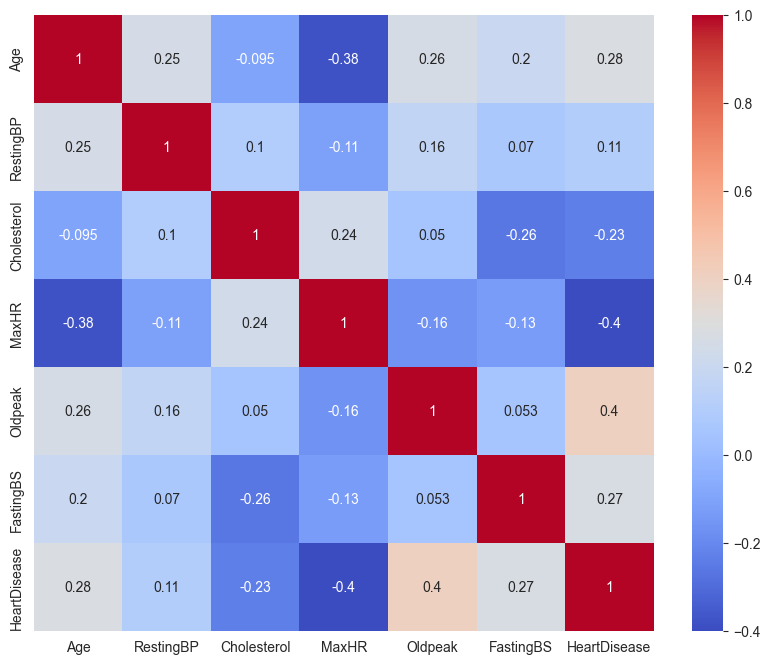

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(heart_data[numerical_features+binary_features+target_feature].corr(), annot=True, cmap='coolwarm')
plt.show()

## Check for duplicates

In [38]:
print(f" In our dataset we have {heart_data.duplicated().sum()} duplicates")

 In our dataset we have 0 duplicates


## Check for Missing Values

In [39]:
heart_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [40]:
heart_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The dataset **doesn't** contain `NaN` or `Null` values.

In [41]:
heart_data.eq(0).sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS         704
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64

- **RestingBP** contains values equal to 0, which are not physiologically possible.
  This suggests this zero represents missing or incorrectly recorded value that should be either removed or imputed.

- **Cholesterol** also includes 0 values. Since a cholesterol level of 0 is impossible, these should also be treated as missing values.
  In total, there are 172 such entries that need to be handled.

- **FastingBS** can legitimately take the value 0, because the feature is binary (0 = normal, 1 = high).
  Therefore, zeros in this column do **not** represent missing values.

- **Oldpeak** can also legitimately be 0, since it represents ST depression relative to rest.
  Thus, values of 0 here are not missing values.


## Data Preprocessing: Missing Value Imputation and Encoding

In [42]:
X_train_eda = X_train.copy()
X_test_eda = X_test.copy()

In [43]:
st_order = [["Down", "Flat", "Up"]]

knn_reference_features = ['Age', 'RestingBP', 'MaxHR', 'Cholesterol']
chol_index = knn_reference_features.index('Cholesterol')

### Replacing 0 by mean value in RestingBP

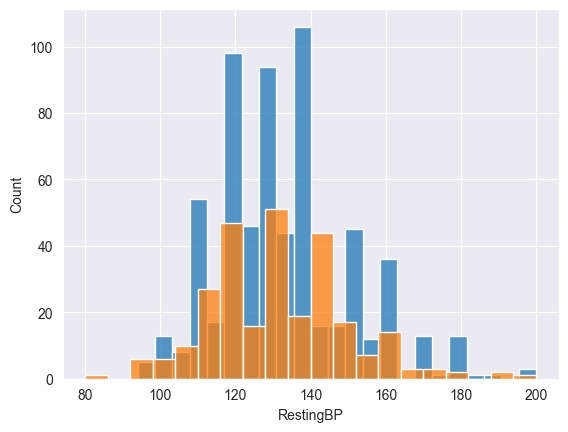

In [44]:
mean_restingBP = heart_data.copy().RestingBP.replace(0, np.nan).mean()
X_train_eda['RestingBP'] = X_train_eda['RestingBP'].replace(0, mean_restingBP)
X_test_eda['RestingBP'] = X_test_eda['RestingBP'].replace(0, mean_restingBP)
sns.histplot(data=X_train_eda, x="RestingBP")
sns.histplot(data=X_test_eda, x="RestingBP")
plt.show()

### Using kNN imputer to replace 0 in Cholesterol column

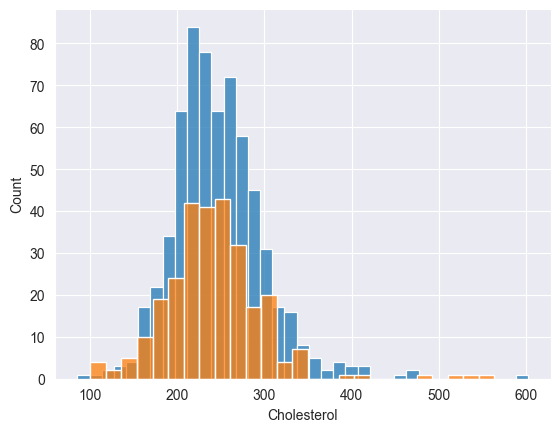

In [45]:
from sklearn.impute import KNNImputer

X_train_eda.Cholesterol = X_train_eda.Cholesterol.replace(0, np.nan)
X_test_eda.Cholesterol = X_test_eda.Cholesterol.replace(0, np.nan)
imputer = KNNImputer(n_neighbors=5)
imputed_data_train = imputer.fit_transform(X_train_eda[knn_reference_features])
imputed_data_test = imputer.transform(X_test_eda[knn_reference_features])
X_train_eda['Cholesterol'] = imputed_data_train[:, chol_index]
X_test_eda['Cholesterol'] = imputed_data_test[:, chol_index]
sns.histplot(data=X_train_eda, x="Cholesterol")
sns.histplot(data=X_test_eda, x="Cholesterol")
plt.show()

### Using Simple imputer to replace 0 by mean in Cholesterol column

In [46]:
# from sklearn.impute import SimpleImputer
# X_train_eda.Cholesterol = X_train_eda.Cholesterol.replace(0, np.nan)
# X_test_eda.Cholesterol = X_test_eda.Cholesterol.replace(0, np.nan)
#
# imputer = SimpleImputer(strategy='mean')  # we can also use 'median'
#
# imputed_data_train = imputer.fit_transform(X_train_eda[knn_reference_features])
# imputed_data_test = imputer.transform(X_test_eda[knn_reference_features])
#
# # Assign imputed Cholesterol column back
# X_train_eda['Cholesterol'] = imputed_data_train[:, chol_index]
# X_test_eda['Cholesterol'] = imputed_data_test[:, chol_index]
#
# # Plot histograms
# sns.histplot(data=X_train_eda, x="Cholesterol")
# sns.histplot(data=X_test_eda, x="Cholesterol")
# plt.show()

## Encoding nominal features

In [47]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
train_ohe = one_hot_encoder.fit_transform(X_train_eda[nominal_features])
test_ohe = one_hot_encoder.transform(X_test_eda[nominal_features])

# npdarray to DataFrame
train_ohe_df = pd.DataFrame(train_ohe, columns=one_hot_encoder.get_feature_names_out(nominal_features))
test_ohe_df = pd.DataFrame(test_ohe, columns=one_hot_encoder.get_feature_names_out(nominal_features))

# Reset index to align DataFrames
train_ohe_df.index = X_train_eda.index
test_ohe_df.index = X_test_eda.index

# Drop original nominal columns
X_train_eda = X_train_eda.drop(columns=nominal_features)
X_test_eda = X_test_eda.drop(columns=nominal_features)

# Concatenate encoded columns
X_train_eda = pd.concat([X_train_eda, train_ohe_df], axis=1)
X_test_eda = pd.concat([X_test_eda, test_ohe_df], axis=1)

## Encoding ordinal features

In [48]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=st_order)
X_train_eda[ordinal_features] = ordinal_encoder.fit_transform(X_train_eda[ordinal_features])
X_test_eda[ordinal_features] = ordinal_encoder.transform(X_test_eda[ordinal_features])


## Model Evaluation

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
    }
    if y_proba is not None:
        metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
    else:
        metrics["roc_auc"] = np.nan
    return metrics

results = []

## Correlation analysis after data preprocessing

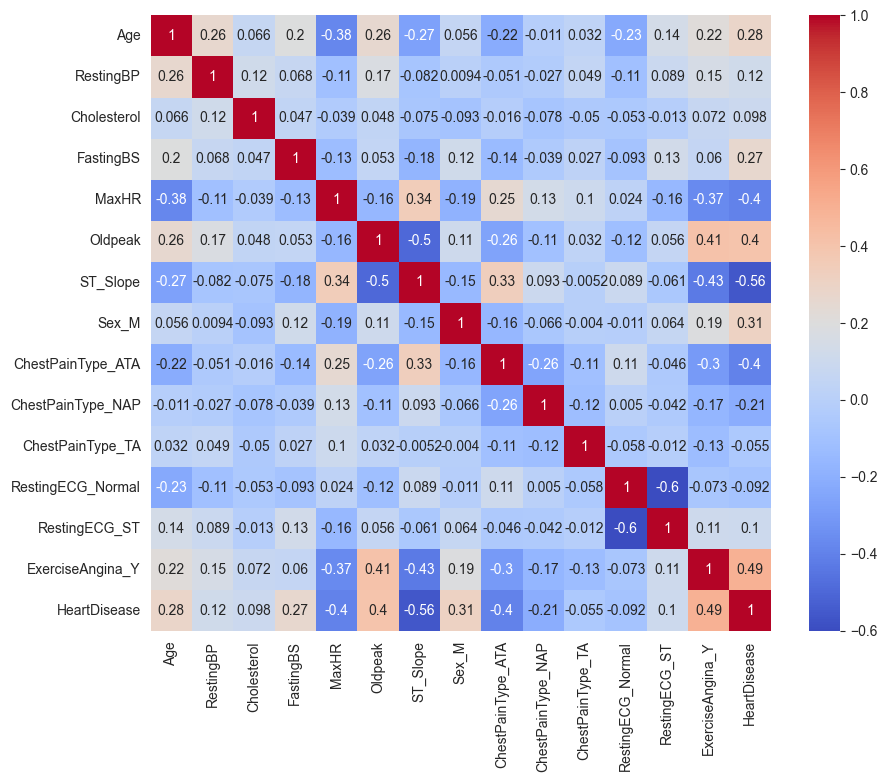

In [50]:
plt.figure(figsize=(10, 8))
df_corr = pd.concat([X_test_eda, X_train_eda], axis=0)
df_corr = pd.concat([df_corr,  heart_data['HeartDisease']], axis=1)
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.show()

# KNN prediction

## Data scailling

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# We will get here np.arrays with only 5 columns of numerical_features
X_train_scaled_numeric = scaler.fit_transform(X_train_eda[numerical_features])
X_test_scaled_numeric = scaler.transform(X_test_eda[numerical_features])

# Convert to DataFrame
X_train_scaled_numeric = pd.DataFrame(X_train_scaled_numeric, columns=numerical_features, index=X_train_eda.index)
X_test_scaled_numeric = pd.DataFrame(X_test_scaled_numeric, columns=numerical_features, index=X_test_eda.index)

# Combine with the non-numerical columns
X_train_eda_scaled = pd.concat(
    [X_train_scaled_numeric, X_train_eda.drop(columns=numerical_features)],
    axis=1
)

X_test_eda_scaled = pd.concat(
    [X_test_scaled_numeric, X_test_eda.drop(columns=numerical_features)],
    axis=1
)

### KNN with GridSearchCV for best hyperparams with recall scoring

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan' , 'minkowski'],
}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=cv, n_jobs=-1, scoring='recall', refit=True)
grid.fit(X_train_eda_scaled, y_train.squeeze())

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

results.append(evaluate_model(grid.best_estimator_, X_test_eda_scaled, y_test, "kNN"))

KeyboardInterrupt: 

In [99]:
results_df = pd.DataFrame(grid.cv_results_)

# Keep only useful columns
results_df = results_df[
    [
        "param_metric",
        "param_n_neighbors",
        "param_weights",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]

best_per_metric = (
    results_df
    .loc[results_df.groupby("param_metric")["mean_test_score"].idxmax()]
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)

print("\nBest hyperparameters for recall per distance metric:")
print(best_per_metric)


Best hyperparameters for recall per distance metric:
  param_metric  param_n_neighbors param_weights  mean_test_score  \
0    manhattan                 10      distance         0.892413   
1    euclidean                  6      distance         0.874936   
2    minkowski                  6      distance         0.874936   

   std_test_score  rank_test_score  
0        0.019821                1  
1        0.025623               26  
2        0.025623               26  


# Decision Tree with GridSearchCV

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2']
}

grid = GridSearchCV(estimator=tree, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='recall')
grid.fit(X_train_eda_scaled, y_train.squeeze())


print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_test_eda_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

results.append(evaluate_model(best_tree, X_test_eda_scaled, y_test, "Decision Tree"))

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20}
Best CV Score: 0.8982097186700766
Accuracy: 0.8152173913043478
Recall: 0.8109756097560976


In [101]:
results_df = pd.DataFrame(grid.cv_results_)

results_df = results_df[
    [
        "param_criterion",
        "param_max_depth",
        "param_min_samples_split",
        "param_min_samples_leaf",
        "param_max_features",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]

best_per_criterion = (
    results_df
    .loc[
        results_df.groupby("param_criterion")["mean_test_score"].idxmax()
    ]
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)

print("\nBest hyperparameters for recall per criterion:")
print(best_per_criterion)



Best hyperparameters for recall per criterion:
  param_criterion param_max_depth  param_min_samples_split  \
0            gini               5                       20   
1         entropy               5                       10   
2        log_loss               5                       10   

   param_min_samples_leaf param_max_features  mean_test_score  std_test_score  \
0                       2               sqrt         0.898210        0.016199   
1                       4               sqrt         0.895269        0.021778   
2                       4               sqrt         0.895269        0.021778   

   rank_test_score  
0                1  
1                7  
2                7  


# Random Forest with RandomizedSearchCV

In [102]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000, 2000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt'],
    'bootstrap': [True, False],
}


random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=100, cv=cv, verbose=1, random_state=42, n_jobs = -1, scoring='recall')


random_search.fit(X_train_eda, y_train.squeeze())


best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_score = random_search.best_score_

print("The best parameters:", best_params)
print("The best score with cross validation:", best_score)


y_pred = best_model.predict(X_test_eda)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy on test values: {accuracy}')
print(f'Recall on test values: {recall}')

results.append(evaluate_model(best_model, X_test_eda, y_test, "Random Forest"))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
The best score with cross validation: 0.906990622335891
Accuracy on test values: 0.8586956521739131
Recall on test values: 0.8658536585365854


In [103]:
results_df = pd.DataFrame(random_search.cv_results_)

results_df = results_df[
    [
        "param_max_features",
        "param_n_estimators",
        "param_max_depth",
        "param_min_samples_split",
        "param_min_samples_leaf",
        "param_bootstrap",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]

best_per_max_features = (
    results_df
    .loc[
        results_df.groupby("param_max_features")["mean_test_score"].idxmax()
    ]
    .sort_values("mean_test_score", ascending=False)
    .reset_index(drop=True)
)

print("\nBest hyperparameters for recall per max_features:")
print(best_per_max_features)


Best hyperparameters for recall per max_features:
  param_max_features  param_n_estimators param_max_depth  \
0               sqrt                 800              30   

   param_min_samples_split  param_min_samples_leaf  param_bootstrap  \
0                        2                       2             True   

   mean_test_score  std_test_score  rank_test_score  
0         0.906991         0.01959                1  


# Logistic Regression with GridSearchCV

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score


# Define solvers and corresponding compatible penalties
solver_penalty_map = {
    'liblinear': ['l1', 'l2'],
    'saga': ['l1', 'l2', 'elasticnet'],
    'lbfgs': ['l2'],
    'newton-cg': ['l2'],
    'sag': ['l2']
}

# Parameter grid
param_grid = [
    {'penalty': ['l1', 'l2'], 'C':[0.01, 0.1, 1, 10, 100]},
    {'penalty': ['elasticnet'], 'C':[0.01, 0.1, 1, 10, 100], 'l1_ratio':[0, 0.5, 1]}
]

scoring = 'recall'

for solver, penalties in solver_penalty_map.items():
    print(f"\nUsing solver: {solver}")

    # Filter param_grid to only include compatible penalties
    filtered_param_grid = []
    for grid in param_grid:
        if 'penalty' in grid:
            filtered_penalties = [p for p in grid['penalty'] if p in penalties]
            if filtered_penalties:
                new_grid = grid.copy()
                new_grid['penalty'] = filtered_penalties
                filtered_param_grid.append(new_grid)
        else:
            filtered_param_grid.append(grid)

    log_reg = LogisticRegression(max_iter=5000, solver=solver)

    grid = GridSearchCV(estimator=log_reg, param_grid=filtered_param_grid,
                        scoring=scoring, cv=cv, n_jobs=-1)
    grid.fit(X_train_eda_scaled, y_train.squeeze())

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_eda_scaled)

    print("Best Parameters:", grid.best_params_)
    print("Best Recall score (CV):", grid.best_score_)
    print("Accuracy on test set:", accuracy_score(y_test, y_pred))
    print("Recall on test set:", recall_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_eda_scaled)[:,1]))

    results.append(evaluate_model(best_model, X_test_eda_scaled, y_test, f"Logistic Regression ({solver})"))



Using solver: liblinear
Best Parameters: {'C': 10, 'penalty': 'l1'}
Best Recall score (CV): 0.8632992327365729
Accuracy on test set: 0.855072463768116
Recall on test set: 0.8414634146341463
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       112
           1       0.91      0.84      0.87       164

    accuracy                           0.86       276
   macro avg       0.85      0.86      0.85       276
weighted avg       0.86      0.86      0.86       276

ROC-AUC: 0.9326001742160279

Using solver: saga
Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Best Recall score (CV): 0.9884057971014493
Accuracy on test set: 0.7282608695652174
Recall on test set: 0.8414634146341463
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.56      0.63       112
           1       0.74      0.84      0.79       164

    accuracy                           0.73       276

# Neural network

In [105]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
# We use KerasClassifier to work with sklearn RandomizedSearchCV to tune hyperparams
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [106]:
def create_model(learning_rate=0.001, dropout_rate=0.0, neurons=64):
    input_dim = X_test_eda_scaled.shape[1]
    optimizer = Adam(learning_rate=learning_rate)
    activation='relu'

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons, activation=activation),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation=activation),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['recall']
    )
    return model

In [107]:
early_stop = EarlyStopping(
    monitor='val_loss', # Watch the loss on the validation data
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Keep the weights from the best epoch
    verbose=0
)

# Wrap the Keras model for Scikit-learn compatibility
model_clf = KerasClassifier(
    model=create_model,
    verbose=1,
    callbacks=[early_stop],
    learning_rate=0.001,
    neurons=64,
    dropout_rate=0.2,
    validation_split=0.2,
)

In [108]:
param_grid = {
    'neurons': [32, 64, 128],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64, 128],
    'epochs': [100, 200, 300],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4],
}

random_search = RandomizedSearchCV(
    estimator=model_clf,
    param_distributions=param_grid,
    scoring='recall',
    cv=cv,
    verbose=0,
    n_jobs=-1,
)

In [109]:
random_search.fit(X_train_eda_scaled, y_train)


best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_


y_pred = best_model.predict(X_test_eda_scaled)


results.append(evaluate_model(best_model, X_test_eda_scaled, y_test, "Neural Network"))


print("Best Parameters:", best_params)
print("Best Recall (CV):", best_score)

Epoch 1/300
Epoch 1/300
Epoch 1/200
Epoch 1/200
Epoch 1/200
Epoch 1/200
Epoch 1/200
Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6926 - recall: 0.6577 - val_loss: 0.5729 - val_recall: 0.9245
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5773 - recall: 0.7022 - val_loss: 0.4841 - val_recall: 0.8627
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5651 - recall: 0.7104 - val_loss: 0.4946 - val_recall: 0.7963
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.7336 - recall: 0.6027 - val_loss: 0.7291 - val_recall: 0.4510
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5684 - recall: 0.7456 - val_loss: 0.5096 - val_recall: 0.8511
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.7286 - recall: 0.6787 - val_loss: 0.7247 - val_recall: 0.8889
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.6934 - recall: 0.7027 - val_loss: 0.6880 - val_recall: 0.7358
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4374 - recall: 0.8288 - val_loss: 0.3905 - val_recall: 0.8679
Epoch 123/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4018 - recall: 0.8393 - val_loss: 0.4322 - val_recall: 0.9216
Epoch 132/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4659 - recall: 0.8202 - val_loss: 0.5090 - val_recall: 0.8511
Epoch 78/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4200 - recall: 0.8000 - val_loss: 0.4586 - val_recall: 0.8431
Epoch 79/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6351 - recall: 0.7477 - val_loss: 0.6434 - val_recall: 0.7170
Epoch 26/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4040 - recall: 0.8643 - val_loss: 0.4422 - val_recall: 0.8519
Epoch 130/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4265 - recall: 0.8288 - val_loss: 0.3897 - val_recall: 0.8679
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4524 - recall: 0.8333 - val_loss: 0.5084 - val_recall: 0.8511
Epoch 79/300
Epoch 124/300
4/4 ━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4470 - recall: 0.8145 - val_loss: 0.4608 - val_recall: 0.8148
Epoch 185/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4516 - recall: 0.8178 - val_loss: 0.5041 - val_recall: 0.8824
Epoch 133/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3340 - recall: 0.8784 - val_loss: 0.3794 - val_recall: 0.9057
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4282 - recall: 0.8527 - val_loss: 0.4614 - val_recall: 0.9412
Epoch 189/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4464 - recall: 0.8145 - val_loss: 0.4602 - val_recall: 0.8148
Epoch 186/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4273 - recall: 0.8571 - val_loss: 0.4608 - val_recall: 0.9412
Epoch 190/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3544 - recall: 0.8643 - val_loss: 0.4170 - val_recall: 0.9074
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.4559 - recall: 0.8246 - val_loss: 0.4999 - val_recall: 0.7872
Epoch 160/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4374 - recall: 0.8054 - val_loss: 0.4520 - val_recall: 0.8148
Epoch 200/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - recall: 0.8114 - val_loss: 0.5188 - val_recall: 0.8723
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4349 - recall: 0.8222 - val_loss: 0.4934 - val_recall: 0.8824
Epoch 149/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4453 - recall: 0.8202 - val_loss: 0.4910 - val_recall: 0.7872
Epoch 175/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4369 - recall: 0.8054 - val_loss: 0.4515 - val_recall: 0.8148
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4446 - recall: 0.8202 - val_loss: 0.4907 - val_recall: 0.7872
Epoch 176/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4339 - recall: 0.8222 - val_loss: 0.4928 - val_recall: 0.8824
Epoch 150/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4440 - recall: 0.8202 - val_loss: 0.4904 - val_recall: 0.7872
Epoch 177/200
1/1 ━━━━━━━━

/Users/aleksandrvlasov/VS Repositories/IA01/IA01-Project/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4433 - recall: 0.8202 - val_loss: 0.4900 - val_recall: 0.7872
Epoch 178/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4320 - recall: 0.8222 - val_loss: 0.4916 - val_recall: 0.8824
Epoch 152/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4856 - recall: 0.8070 - val_loss: 0.5137 - val_recall: 0.8723
Epoch 10/100
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4427 - recall: 0.8202 - val_loss: 0.4894 - val_recall: 0.7872
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4310 - recall: 0.8222 - val_loss: 0.4910 - val_recall: 0.8824
Epoch 179/200
Epoch 153/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4682 - recall: 0.8202 - val_loss: 0.5061 - val_recall: 0.8723
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4421 - recall: 0.8202 - val_loss: 0.4887 - val_recall: 0.7872
Epoch 180/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4301 - recall: 0.8267 - val_loss: 0.4902 - val_recall: 0.8824
Epoch 154/

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3281 - recall: 0.8816 - val_loss: 0.4758 - val_recall: 0.9574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6210 - recall: 0.5991 - val_loss: 0.5767 - val_recall: 0.7736
Epoch 31/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6304 - recall: 0.6161 - val_loss: 0.6196 - val_recall: 0.8431
Epoch 24/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6770 - recall: 0.6787 - val_loss: 0.6242 - val_recall: 0.6852
Epoch 23/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6072 - recall: 0.6351 - val_loss: 0.5744 - val_recall: 0.7925
Epoch 32/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6211 - recall: 0.6607 - val_loss: 0.6176 - val_recall: 0.8431
Epoch 25/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6706 - recall: 0.6471 - val_loss: 0.6223 - val_recall: 0.7037
Epoch 24/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7102 - 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6498 - recall: 0.6697 - val_loss: 0.6201 - val_recall: 0.7407
Epoch 25/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5985 - recall: 0.6216 - val_loss: 0.5703 - val_recall: 0.8113
Epoch 34/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7097 - recall: 0.6267 - val_loss: 0.6694 - val_recall: 0.6863
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6274 - recall: 0.6830 - val_loss: 0.6130 - val_recall: 0.8431
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5565 - recall: 0.5909Epoch 27/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6561 - recall: 0.6787 - val_loss: 0.6181 - val_recall: 0.7407
Epoch 26/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7072 - recall: 0.5556 - val_loss: 0.6644 - val_recall: 0.7059
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5987 - recall: 0.6216 - val_loss: 0.5681 - val_recall: 0.8302
Epoch 35/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6686 - reca

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5818 - recall: 0.7511 - val_loss: 0.5504 - val_recall: 0.7963
Epoch 60/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5326 - recall: 0.7297 - val_loss: 0.5102 - val_recall: 0.8491
Epoch 69/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5730 - recall: 0.7366 - val_loss: 0.5295 - val_recall: 0.8824
Epoch 61/200
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5934 - recall: 0.7059 - val_loss: 0.5485 - val_recall: 0.7963
Epoch 61/200
Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5508 - recall: 0.7467 - val_loss: 0.5545 - val_recall: 0.8431
Epoch 39/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5680 - recall: 0.7232 - val_loss: 0.5274 - val_recall: 0.8824
Epoch 62/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5338 - recall: 0.7387 - val_loss: 0.5087 - val_recall: 0.8491
Epoch 70/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5980 - recall: 0.6968 - val_loss: 0.5467 - val_recall: 0.7

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6558 - recall: 0.7281 - val_loss: 0.6315 - val_recall: 0.8085
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5181 - recall: 0.7873 - val_loss: 0.4848 - val_recall: 0.8148
Epoch 98/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4937 - recall: 0.7911 - val_loss: 0.4989 - val_recall: 0.8824
Epoch 76/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4799 - recall: 0.7991 - val_loss: 0.4634 - val_recall: 0.8824
Epoch 99/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5120 - recall: 0.7432 - val_loss: 0.4732 - val_recall: 0.8679
Epoch 106/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5343 - recall: 0.7692 - val_loss: 0.4833 - val_recall: 0.8148
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4996 - recall: 0.7568 - val_loss: 0.4725 - val_recall: 0.8679
Epoch 107/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5017 - recall: 0.8080 - val_loss: 0.4620 - val_recall: 0.8824
Epoch 99/200
Epoch 100/200
13/13

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4210 - recall: 0.8533 - val_loss: 0.4469 - val_recall: 0.9412
Epoch 176/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4815 - recall: 0.8190 - val_loss: 0.4160 - val_recall: 0.8333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 198/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3172 - recall: 0.8914 - val_loss: 0.4138 - val_recall: 0.8519
Epoch 26/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5031 - recall: 0.8026 - val_loss: 0.5140 - val_recall: 0.8511
Epoch 112/200
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4967 - recall: 0.8421Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3131 - recall: 0.8959 - val_loss: 0.4165 - val_recall: 0.8519
Epoch 27/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4610 - recall: 0.8371 - val_loss: 0.4159 - val_recall: 0.8333
Epoch 199/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5028 - recall: 0.8114 - val_loss: 0.5135 - val_

# SVM

In [110]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score


# Define the SVM model
svm_model = SVC(probability=True)  # probability=True for ROC-AUC later

# Define hyperparams
param_distributions = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],      # only used if kernel='poly'
    'class_weight': ['balanced']
}

# Randomized Search
random_search = RandomizedSearchCV(estimator=svm_model,
                                   param_distributions=param_distributions,
                                   n_iter=30,       # number of random combinations
                                   scoring='roc_auc',
                                   cv=cv,
                                   verbose=1,
                                   n_jobs=-1,
                                   return_train_score=True)


random_search.fit(X_train_eda_scaled, y_train)


best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_


y_pred = best_model.predict(X_test_eda_scaled)


results.append(evaluate_model(best_model, X_test_eda_scaled, y_test, f"SVM (Randomized Search)"))


print("Best Parameters:", best_params)
print("Best Recall (CV):", best_score)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 0.01, 'class_weight': 'balanced', 'C': 10}
Best Recall (CV): 0.9018346771280361


## Compare best models

In [111]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="recall", ascending=False)
results_df


,model,accuracy,precision,recall,f1,roc_auc
0,kNN,0.873188,0.905660,0.878049,0.891641,0.931430
2,Random Forest,0.858696,0.893082,0.865854,0.879257,0.934832
9,SVM (Randomized Search),0.858696,0.903226,0.853659,0.877743,0.922583
5,Logistic Regression (lbfgs),0.851449,0.896774,0.847561,0.871473,0.922855
6,Logistic Regression (newton-cg),0.851449,0.896774,0.847561,0.871473,0.922964
7,Logistic Regression (sag),0.851449,0.896774,0.847561,0.871473,0.922964
3,Logistic Regression (liblinear),0.855072,0.907895,0.841463,0.873418,0.932600
4,Logistic Regression (saga),0.728261,0.737968,0.841463,0.786325,0.805858
8,Neural Network,0.840580,0.900000,0.823171,0.859873,0.936139
1,Decision Tree,0.815217,0.869281,0.810976,0.839117,0.862505
